<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Structured_data_learning_with_Wide%2C_Deep%2C_and_Cross_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)

raw_data = pd.read_csv(data_url, header=None)

In [ ]:
print(f"Dataset shape: {raw_data.shape}")

Dataset shape: (581012, 55)


In [ ]:
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

soil_type = raw_data.loc[:, 14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)
wilderness_area = raw_data.loc[:, 10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

In [ ]:
CSV_HEADER = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

In [ ]:
data = pd.concat([raw_data.loc[:, 0:9], wilderness_area, soil_type, raw_data.loc[:,54]],
                 axis = 1,
                 ignore_index = True)

data.columns = CSV_HEADER

data["Cover_Type"] = data["Cover_Type"] - 1
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (581012, 13)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,area_type_1,soil_type_29,4
1,2590,56,2,212,-6,390,220,235,151,6225,area_type_1,soil_type_29,4
2,2804,139,9,268,65,3180,234,238,135,6121,area_type_1,soil_type_12,1
3,2785,155,18,242,118,3090,238,238,122,6211,area_type_1,soil_type_30,1
4,2595,45,2,153,-1,391,220,234,150,6172,area_type_1,soil_type_29,4


In [ ]:
train_splits = []
test_splits = []

for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")


Train split size: 493735
Test split size: 87277


In [ ]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [ ]:
TARGET_FEATURE_NAME = "Cover_Type"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]

NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)


In [ ]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [ ]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 50

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = index(inputs[feature_name])
            if use_embedding:
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding_ecoder = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding_ecoder(value_index)
            else:
                # Create a one-hot encoder.
                onehot_encoder = CategoryEncoding(output_mode="binary")
                onehot_encoder.adapt(index(vocabulary))
                # Convert the index values to a one-hot representation.
                encoded_feature = onehot_encoder(value_index)
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_30')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_30')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_31')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_30')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_31')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_32')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_30')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_31')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_32')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_33')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_30')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by laye

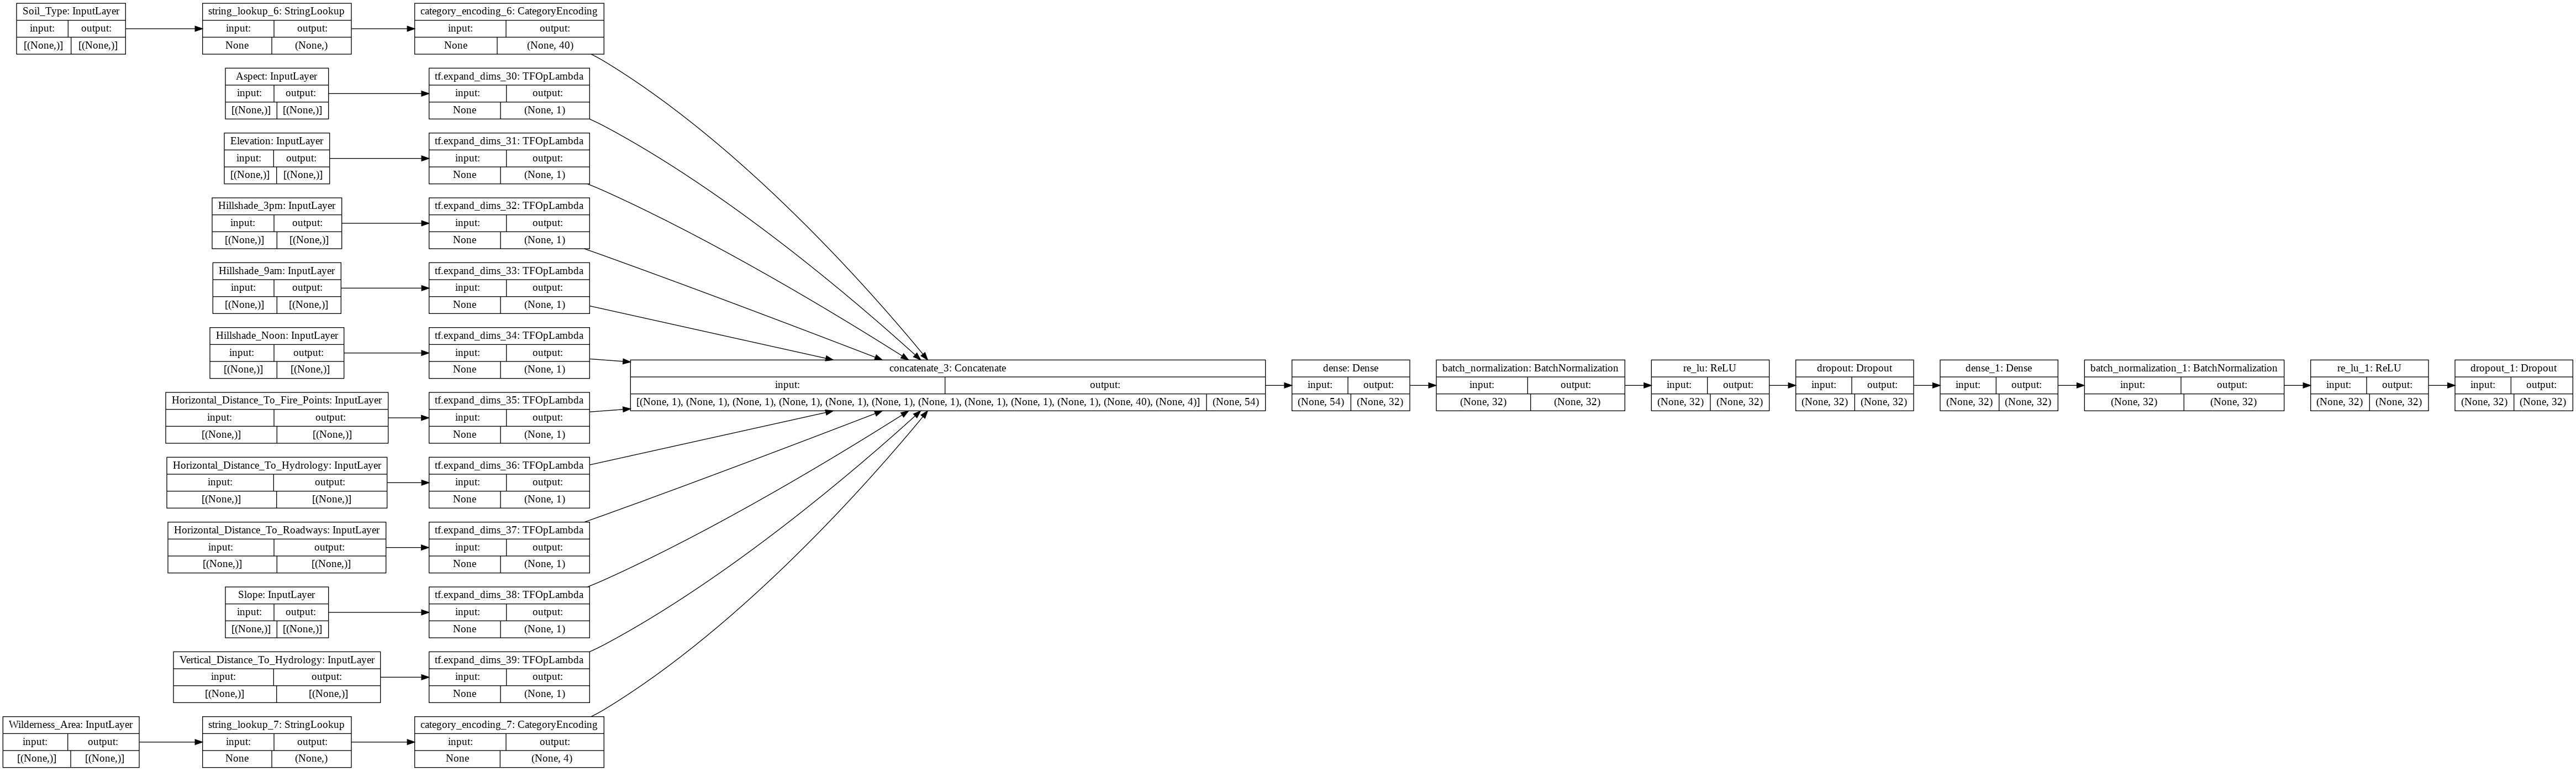

In [ ]:
def create_baseline_model():
  inputs = create_model_inputs()
  features = encode_inputs(inputs)

  for units in hidden_units:
    features = tf.keras.layers.Dense(units)(features)
    features = tf.keras.layers.BatchNormalization()(features)
    features = tf.keras.layers.ReLU()(features)
    features = tf.keras.layers.Dropout(dropout_rate)(features)

  outputs = tf.keras.layers.Dense(units = NUM_CLASSES, activation='softmax')(features)
  model = tf.keras.Model(inputs = inputs, outputs = features)
  return model

baseline_model = create_baseline_model()
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(baseline_model)


Start training the model...
Epoch 1/50
1864/1864 [==============================] - 16s 7ms/step - loss: 6.2455 - sparse_categorical_accuracy: 0.3168
Epoch 2/50
1864/1864 [==============================] - 8s 4ms/step - loss: 3.2777 - sparse_categorical_accuracy: 0.4185
Epoch 3/50
1864/1864 [==============================] - 8s 4ms/step - loss: 3.2144 - sparse_categorical_accuracy: 0.4255
Epoch 4/50
1864/1864 [==============================] - 8s 4ms/step - loss: 3.1863 - sparse_categorical_accuracy: 0.4180
Epoch 5/50
1864/1864 [==============================] - 9s 5ms/step - loss: 3.1938 - sparse_categorical_accuracy: 0.4123
Epoch 6/50
1864/1864 [==============================] - 8s 4ms/step - loss: 3.2261 - sparse_categorical_accuracy: 0.4201
Epoch 7/50
1864/1864 [==============================] - 8s 4ms/step - loss: 3.3389 - sparse_categorical_accuracy: 0.4093
Epoch 8/50
1864/1864 [==============================] - 8s 4ms/step - loss: 3.3896 - sparse_categorical_accuracy: 0.3927
Epo

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_40')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_40')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_41')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_40')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_41')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_42')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_40')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_41')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_42')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_43')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_40')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by laye

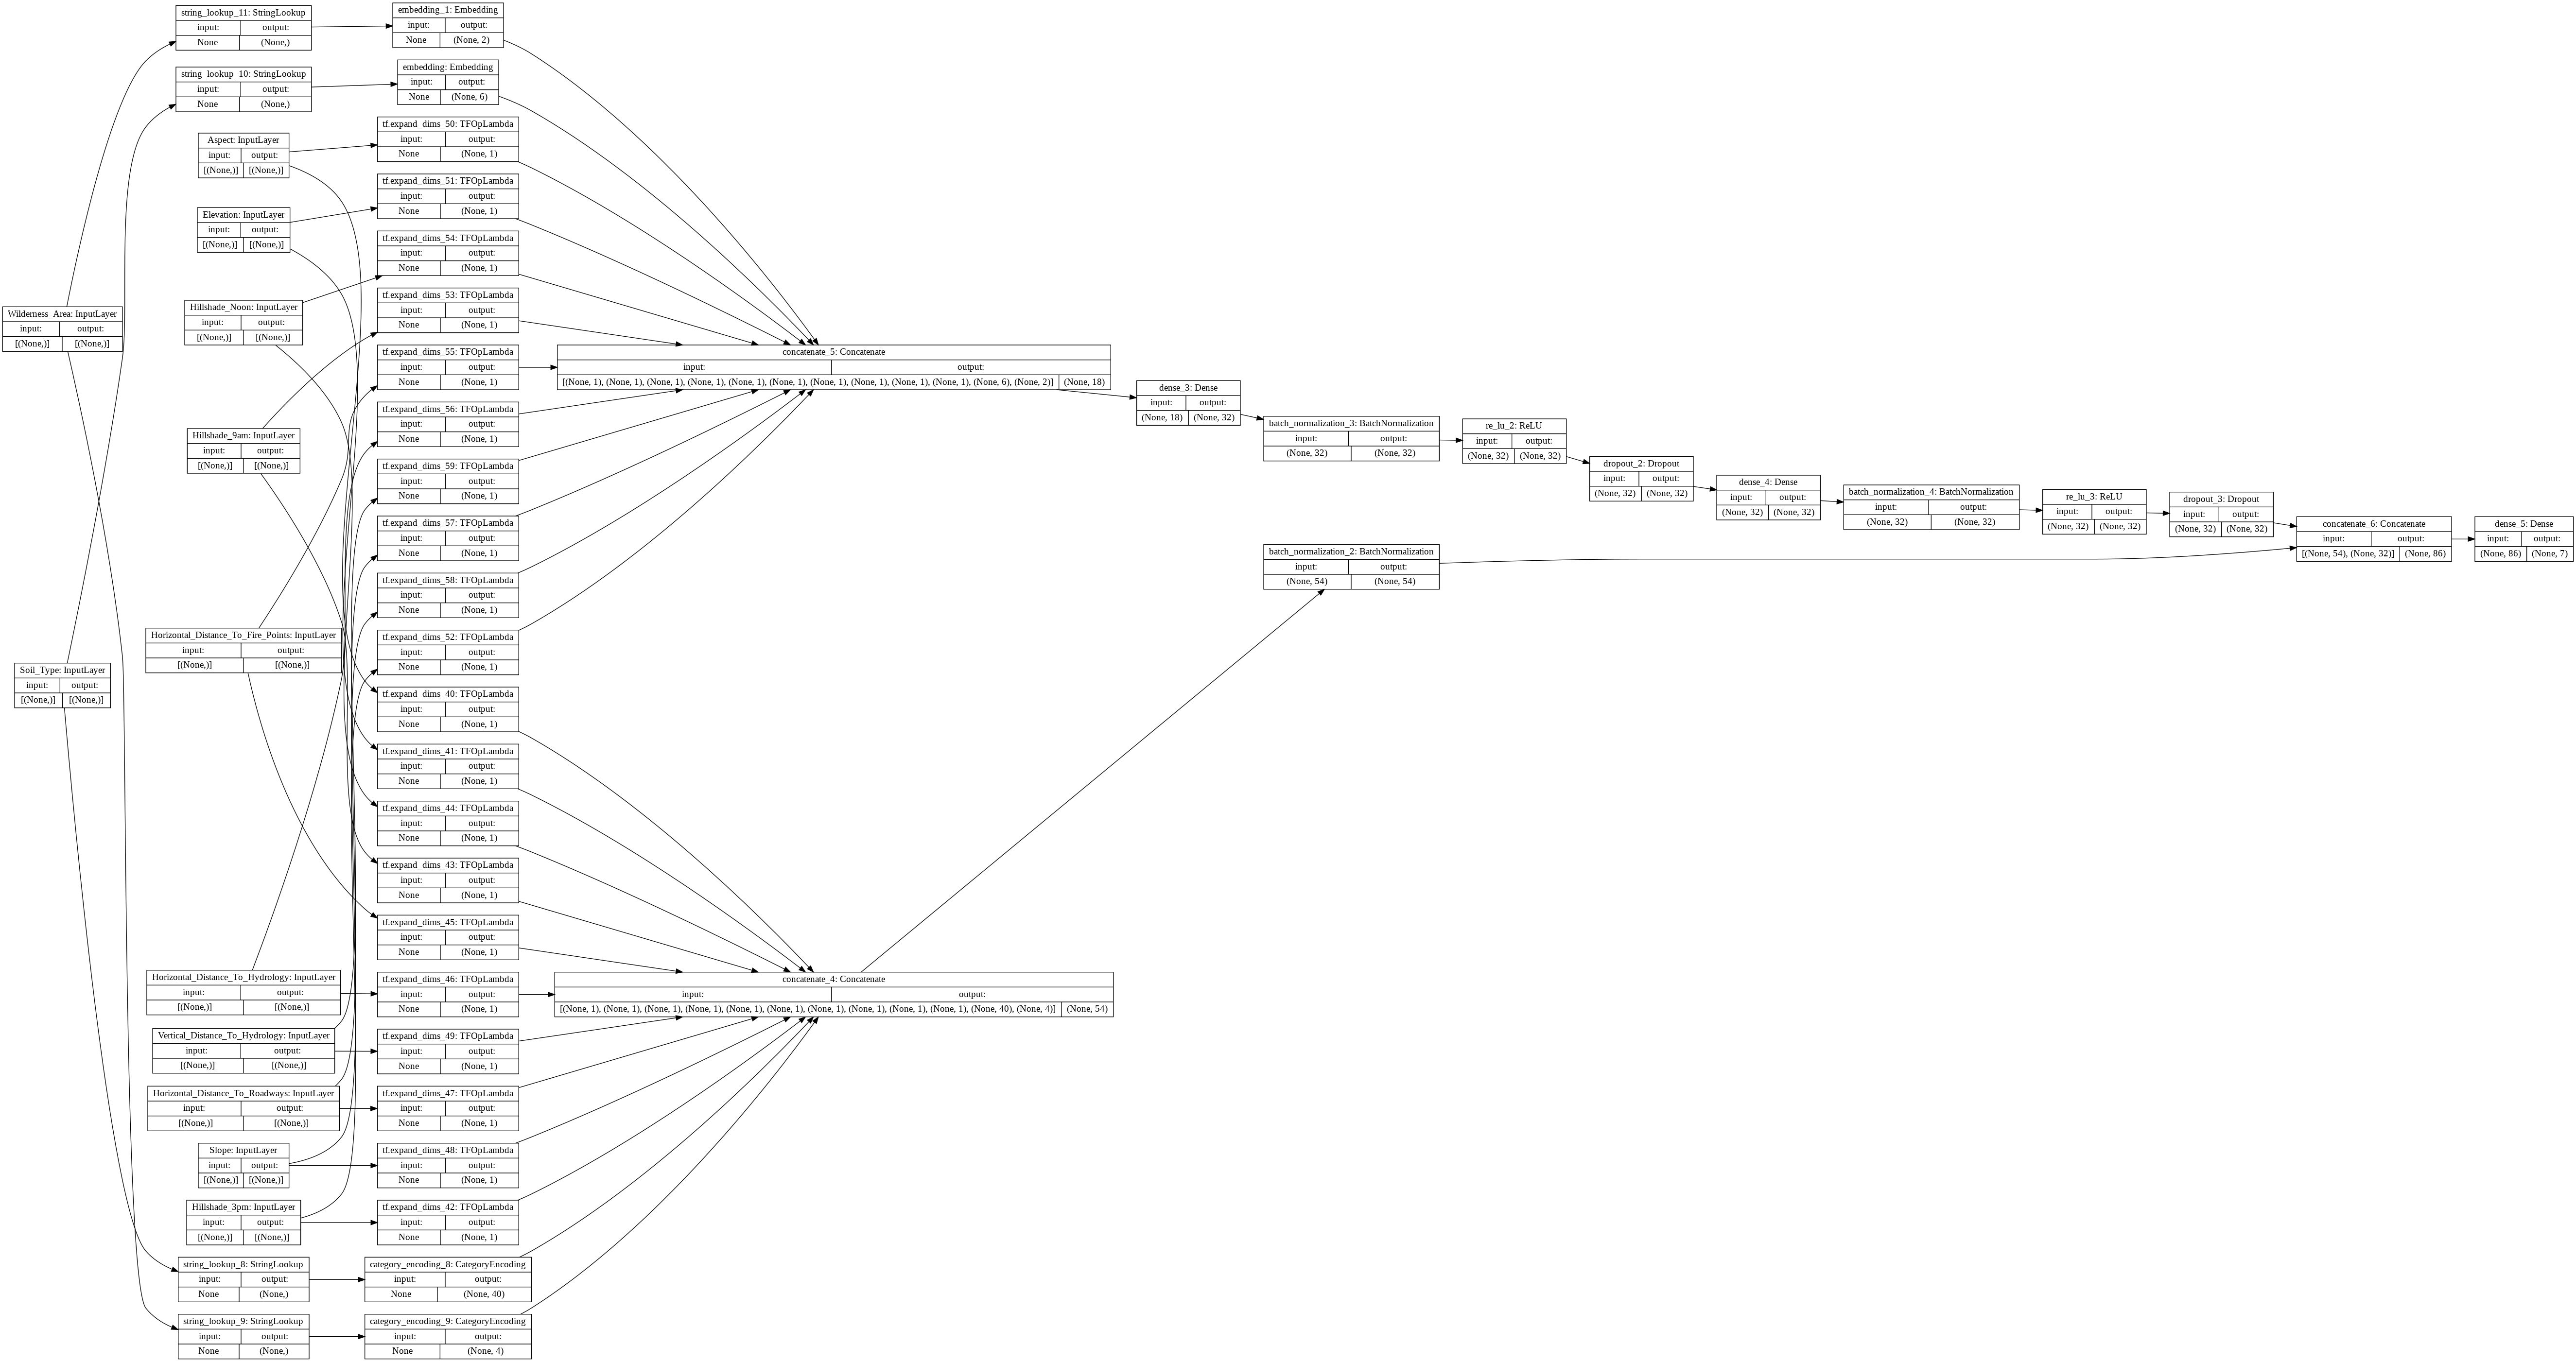

In [ ]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
keras.utils.plot_model(wide_and_deep_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(wide_and_deep_model)


Start training the model...
Epoch 1/50
1864/1864 [==============================] - 16s 8ms/step - loss: 0.9268 - sparse_categorical_accuracy: 0.6366
Epoch 2/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.7382
Epoch 3/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5879 - sparse_categorical_accuracy: 0.7466
Epoch 4/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.7517
Epoch 5/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5660 - sparse_categorical_accuracy: 0.7555
Epoch 6/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5581 - sparse_categorical_accuracy: 0.7592
Epoch 7/50
1864/1864 [==============================] - 10s 6ms/step - loss: 0.5514 - sparse_categorical_accuracy: 0.7623
Epoch 8/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5472 - sparse_categorical_accuracy: 0.76

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_60')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_60')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_61')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_60')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_61')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_62')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_60')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_61')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_62')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_63')>]
[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.expand_dims_60')>, <KerasTensor: shape=(None, 1) dtype=float32 (created by laye

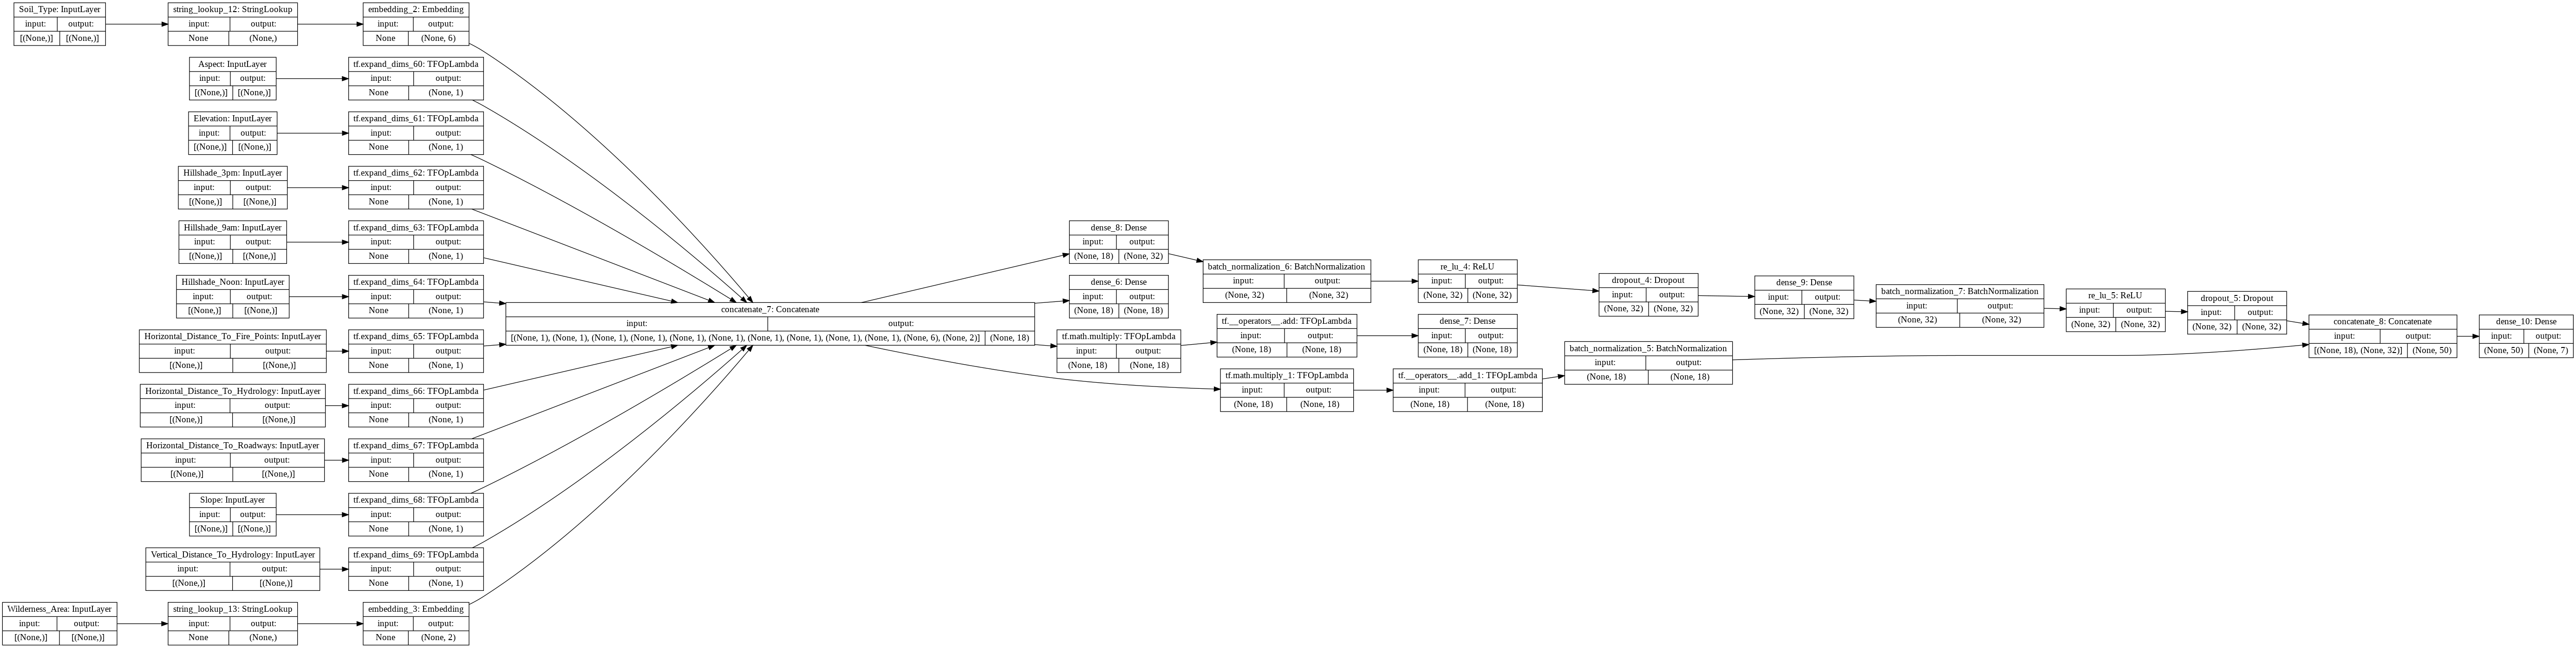

In [ ]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
keras.utils.plot_model(deep_and_cross_model, show_shapes=True, rankdir="LR")

In [ ]:
run_experiment(deep_and_cross_model)


Start training the model...
Epoch 1/50
1864/1864 [==============================] - 15s 7ms/step - loss: 0.8276 - sparse_categorical_accuracy: 0.6674
Epoch 2/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5985 - sparse_categorical_accuracy: 0.7429
Epoch 3/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5791 - sparse_categorical_accuracy: 0.7493
Epoch 4/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5671 - sparse_categorical_accuracy: 0.7537
Epoch 5/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5595 - sparse_categorical_accuracy: 0.7564
Epoch 6/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5535 - sparse_categorical_accuracy: 0.7582
Epoch 7/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5475 - sparse_categorical_accuracy: 0.7601
Epoch 8/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.5430 - sparse_categorical_accuracy: 0.76